### Figure 2: Cell Turnover, Anisomycin Effects, and Placefield Stability Remapping

In [1]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd


# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc

Set up main figure for plotting

[8.5 6.5]


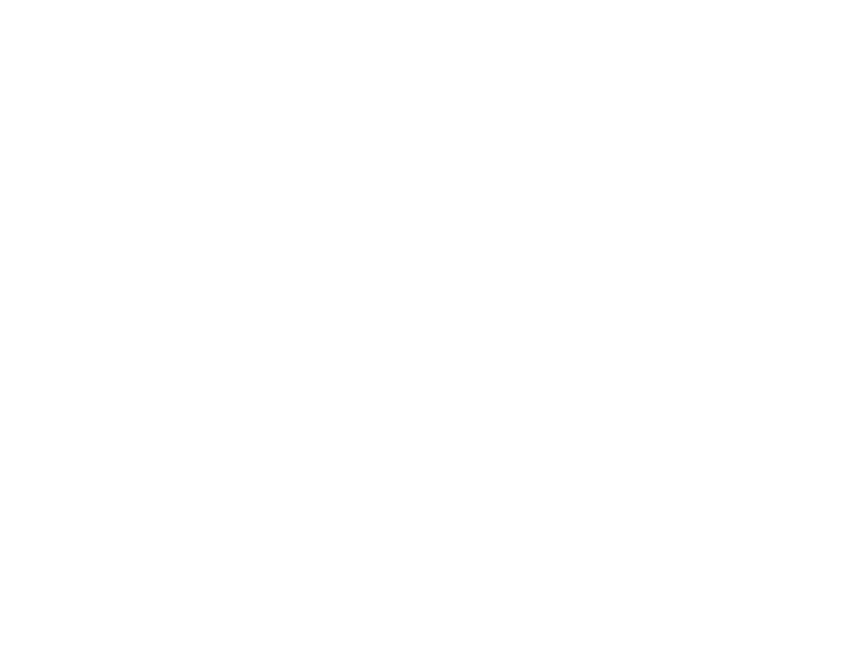

In [2]:
# Set up main figure plotting
%matplotlib ipympl
Fig2 = Fig(num=2, grid=(4, 4), size=(8.5, 6.5), fontsize=6)
print(Fig2.fig.get_size_inches())

[8.5 6.5]


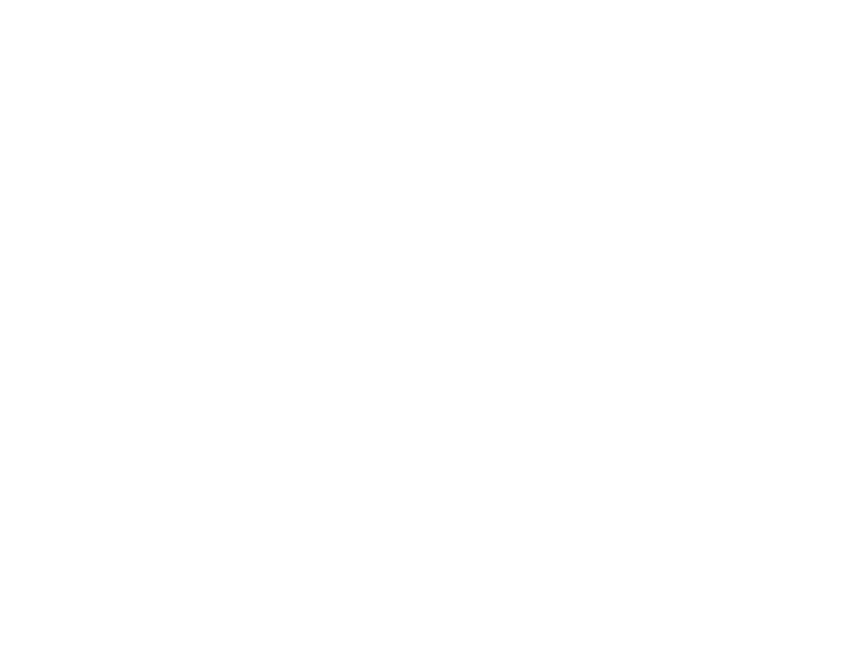

In [3]:
# Set up stats figure
Fig2stats = Fig(num="Figure 2 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6)
print(Fig2.fig.get_size_inches())
Fig2comb = FigMirror(Fig2, Fig2stats)

Plots #3/4: Cell turnover across days

In [4]:
# Test code for reshaping - want 1st index from 3rd dim folded into 2nd, e.g. combine shock v shock and open v open
# Not currently used, but could be useful if we need to add in "open" v "open" overlaps at some later point, no
# currently included, only "shock" v "shock"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a[:, :, 1] = a[:, :, 1]*10
print(a)
# So 1, 4, 7, and 20, 50, 80 are same arena, 3, 6, 9 are different
b = np.append(a, np.nan*np.ones_like(a[:, :, 2, None]), axis=2)
c = b.reshape((int(b.shape[0]*2), b.shape[1], int(b.shape[2]/2)), order='F')
print('3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80')
print(c[:, :, 0])
print('3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan')
print(c[:, :, 1])
# Ok, so this works - things are grouped appropriately

[[[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]

 [[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]]
3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80
[[ 1.  7. 50.]
 [ 1.  7. 50.]
 [ 4. 20. 80.]
 [ 4. 20. 80.]]
3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan
[[ 3.  9. nan]
 [ 3.  9. nan]
 [ 6. nan nan]
 [ 6. nan nan]]


In [5]:
plot_ind = False

axolap_ctrl = Fig2.subplot(441)
axolap_ani = Fig2.subplot(442)

oratioboth_comb = []
for ax, mice, group_title in zip([axolap_ctrl, axolap_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
    days = [-1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
#     arenas = ['Shock', 'Open']
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days):
            for ida, arena_pair in enumerate(arenas):
                try:
#                     oratio1[idm, idd, ida], oratio2[idm, idd, ida], oratioboth[idm, idd, ida], \
#                         oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
#                         pfs.get_overlap(mouse, 'Open', -2, arena, day)
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], -2, arena_pair[1], day)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days)
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
#     # Now reshape things in oratio both to make plotting easier - see above code block for sanity check - not working
#     temp = np.append(oratioboth, np.nan*np.ones_like(oratioboth[:, :, 2, None]), axis=2)
#     oratioboth_rs = temp.reshape((int(temp.shape[0]*2), temp.shape[1], int(temp.shape[2]/2)), order='F')
    

#     fig, ax = er.plot_overlaps(oratioboth, days=days)
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.05, 0.05], colors = ['b', 'r'], 
                              arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.0)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')
#     fig2, ax2 = er.plot_overlaps(oratiomax, days=days)
#     ax2.set_title(group_title + ' Max normalized')
#     fig3, ax3 = er.plot_overlaps(oratiomin, days=days)
#     ax3.set_title(group_title + ' Min normalized')
    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.

No neural data for Marble14: 8/16/2018-s3
No neural data for Marble14: 8/17/2018-s1
No neural data for Marble14: 8/18/2018-s1
No neural data for Marble14: 8/23/2018-s1


Now quantify accelerated change and then slower change (measured by cell overlap) due to ANI administration

In [6]:
# Dump data into dataframe for easy plotting in seaborn afterward...
day_pairs = ['-1_4', '4_1', '1_2', '2_7']
grp_list, dolap_list, day_list = [], [], []
for idg, grp in enumerate(['Ctrl', 'ANI']):
    oratio_use = oratioboth_comb[idg]
    for idd, day_pair in enumerate(day_pairs):
        dolap = oratio_use[:, idd, :].reshape(-1) - oratio_use[:, idd + 1, :].reshape(-1)
        dolap_list.extend(dolap)
        grp_list.extend(len(dolap)*[grp])
        day_list.extend(len(dolap)*[day_pair])

dolap_df = pd.DataFrame({'day_pair': day_list, 'dolap': dolap_list, 'Group': grp_list})

In [7]:
axolap_bw, axolap_bw_stats = Fig2comb.subplot(443)

# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
sns.stripplot(data=dolap_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, ax=axolap_bw, size=3)
axolap_bw.set_ylabel(r'$\Delta_{overlap}$')
axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
axolap_bw.set_xlabel('Day Pair')

Text(0.5, 0, 'Day Pair')

In [8]:
ytext = 0.7
axolap_bw_stats.text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_df['day_pair']):
    ctrl = dolap_df[(dolap_df['Group'] == 'Ctrl') & (dolap_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_df[(dolap_df['Group'] == 'ANI') & (dolap_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit')
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    axolap_bw_stats.text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

day pair -1_4: pval=0.000311 with tstat=-4.24
day pair 2_7: pval=0.136 with tstat=-1.54
day pair 1_2: pval=0.323 with tstat=1.01
day pair 4_1: pval=0.044 with tstat=2.13


Control: p=0.036551324495415816
Anisomycin: p=0.0004309402221784835


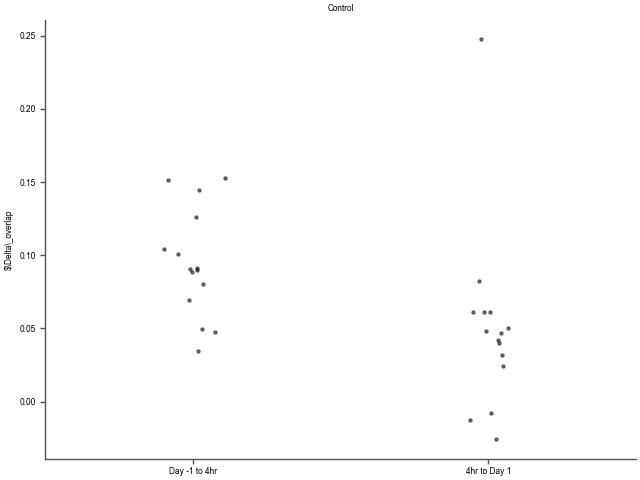

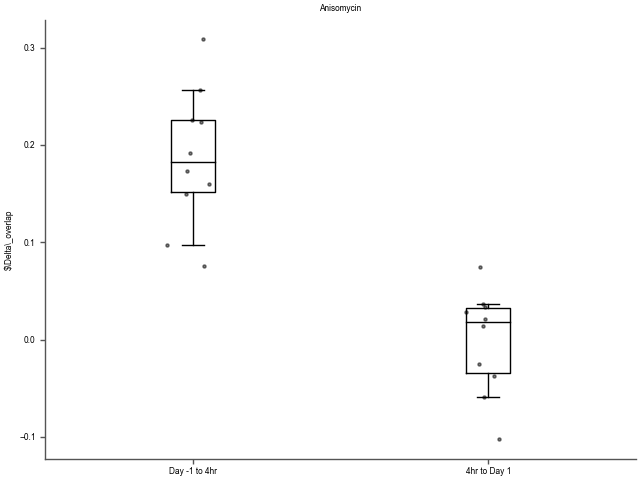

In [9]:
## Plot scatterboxes for change from day -1 to 4hr and 4hr to day 1
from plot_functions import scatter_box
import scipy.stats as sstats

# Remove marble14/20 for now, fix once data points are recovered
for grp, oratio_use in zip(['Control', 'Anisomycin'], oratioboth_comb):
# if group is 'Control':
#     oratio_good = oratioboth[[0, 1, 2, 3, 5], :, :]
#     oratio_goodc = oratio_good
# elif group is 'Anisomycin':
#     oratio_good = oratio_use
#     oratio_gooda = oratio_good

    fig, ax = scatter_box([oratio_use[:, 0, :].reshape(-1) - oratio_use[:, 1, :].reshape(-1),
                           oratio_use[:, 1, :].reshape(-1) - oratio_use[:, 2, :].reshape(-1)],
                          xlabels=['Day -1 to 4hr', '4hr to Day 1'], ylabel=r'$\Delta\_overlap',
                          alpha=0.5)

    ax.set_title(grp)
# fig.savefig(os.path.join(pathname, group_title + ' Change in Overlap after Injection.pdf'))

    # Stats are a bit weird - even though it looks like ANI guys start out super steep and then level off,
    # Control guys do a bit of the same, though to a lesser extent
    t_doverlap, pt_doverlap = sstats.ttest_rel(oratio_use[:, 0, :].reshape(-1) - oratio_use[:, 1, :].reshape(-1),
                            oratio_use[:, 1, :].reshape(-1) - oratio_use[:, 2, :].reshape(-1), nan_policy='omit')
    print(grp + ': ' + 'p=' + str(pt_doverlap))

## Get pvals for between group comparisons...
# First run top two cells with each group, then run this cell

t_do_bw1, p_do_bw1 = sstats.ttest_ind(oratioboth_comb[0][:, 0, :].reshape(-1) - oratioboth_comb[0][:, 1, :].reshape(-1),
                                      oratioboth_comb[1][:, 0, :].reshape(-1) - oratioboth_comb[1][:, 1, :].reshape(-1),
                                      nan_policy='omit')

t_do_bw2, p_do_bw2 = sstats.ttest_ind(oratioboth_comb[0][:, 1, :].reshape(-1) - oratioboth_comb[0][:, 2, :].reshape(-1),
                                      oratioboth_comb[1][:, 1, :].reshape(-1) - oratioboth_comb[1][:, 2, :].reshape(-1),
                                      nan_policy='omit')


In [10]:
# ## Plot Number of Neurons active for each session

# import placefield_stability as pfs
# import er_plot_functions as er
# import os
# import matplotlib.pyplot as plt
# import cell_tracking as ct
# import eraser_reference as err

# group_title = 'Anisomycin'
# if group_title is 'Control':
#     mice = err.control_mice_good
# elif group_title is 'Anisomycin':
#     mice = err.ani_mice_good
# days = [-2, -1, 4, 1, 2, 7]

# arenas = ['Shock', 'Open']

# # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
# pathname = r'C:\Users\kinsky.AD\Dropbox\Imaging Project\Manuscripts\Eraser\Figures'  # Plotting folder
# nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)

# fig, ax = ct.plot_num_neurons(nneurons)
# ax.set_title(group_title)
# fig.savefig(os.path.join(pathname, group_title + ' - ' + 'NumNeurons.pdf'))

# fig2, ax2 = ct.plot_num_neurons(nneurons, normalize='1')
# ax2.set_title(group_title)
# fig2.savefig(os.path.join(pathname, group_title + ' - ' + 'NumNeuronsNorm.pdf'))

# # Combine and plot
# nneurons_comb = np.expand_dims(np.concatenate((nneurons[:, 0, :], nneurons[:, 1, :])), 1)
# figc, axc = ct.plot_num_neurons(nneurons_comb)
# axc.set_title(group_title + ' Combined')
# figc.savefig(os.path.join(pathname, group_title + ' Combined - ' + 'NumNeurons.pdf'))

# ## Get stats for difference between all the above!
# import scipy.stats as stats
# import cell_tracking as ct
# import eraser_reference as err
# import matplotlib.pyplot as plt
# import os as os
# pathname = r'C:\Users\kinsky.AD\Dropbox\Imaging Project\Manuscripts\Eraser\Figures'  # Plotting folder
# days = [-2, -1, 4, 1, 2, 7]
# day_labels = ['-2', '-1', '4hr', '1', '2', '7']
# arenas = ['Shock', 'Open']
# norm_day = -1  # use -1 until you fix Marble20 day -2 data, then use -2

# norm_sesh_ind = [days.index(i) for i in days if norm_day == i][0]
# nneurons_c = ct.get_group_num_neurons(err.control_mice_good, days=days, arenas=arenas)
# nnormc = ct.norm_num_neurons(nneurons_c, norm_sesh_ind)
# nneurons_a = ct.get_group_num_neurons(err.ani_mice_good, days=days, arenas=arenas)
# nnorma = ct.norm_num_neurons(nneurons_a, norm_sesh_ind)

# ## Do ANOVA for number neurons changing across all days
# nmice, narena, ndays = nneurons_a.shape


# # Friedman test - probably not enough samples for this to be legit
# # Omit day -2 (index 0) for now due to nans from Marble20
# stata, pfra = stats.friedmanchisquare(nneurons_a[:, :, 1].reshape(-1), nneurons_a[:, :, 2].reshape(-1),
#                             nneurons_a[:, :, 3].reshape(-1), nneurons_a[:, :, 4].reshape(-1),
#                             nneurons_a[:, :, 5].reshape(-1))


# statc, pfrc = stats.friedmanchisquare(nneurons_c[:, :, 0].reshape(-1), nneurons_c[:, :, 1].reshape(-1),
#                             nneurons_c[:, :, 2].reshape(-1), nneurons_c[:, :, 3].reshape(-1),
#                             nneurons_c[:, :, 4].reshape(-1), nneurons_c[:, :, 5].reshape(-1))

# # ANOVA - really should be a repeated measures ANOVA
# stata, panovaa = stats.f_oneway(nneurons_a[:, :, 1].reshape(-1), nneurons_a[:, :, 2].reshape(-1),
#                             nneurons_a[:, :, 3].reshape(-1), nneurons_a[:, :, 4].reshape(-1),
#                             nneurons_a[:, :, 5].reshape(-1))
# stata_nrm, panovaa_nrm = stats.f_oneway(nnorma[:, :, 1].reshape(-1),
#                             nnorma[:, :, 3].reshape(-1), nnorma[:, :, 4].reshape(-1),
#                             nnorma[:, :, 5].reshape(-1))
# # Omit Marble 14 day 2 due to missing data
# statc, panovac = stats.f_oneway(nneurons_c[:, :, 0].reshape(-1), nneurons_c[:, :, 1].reshape(-1),
#                                 nneurons_c[:, :, 2].reshape(-1), nneurons_c[:, :, 3].reshape(-1),
#                                 nneurons_c[[0, 1, 2, 3, 5], :, 4].reshape(-1),
#                                 nneurons_c[:, :, 5].reshape(-1))
# statc_nrm, panovac_nrm = stats.f_oneway(nnormc[:, :, 0].reshape(-1),
#                                         nnormc[:, :, 2].reshape(-1), nnormc[:, :, 3].reshape(-1),
#                                         nnormc[[0, 1, 2, 3, 5], :, 4].reshape(-1),
#                                         nnormc[:, :, 5].reshape(-1))
# ## Do post-hoc comparisons
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Remove marble20 since he has NaNs for day -1
# nnorma_no20 =nnorma[[0, 1, 3], :, :]
# groupsa = np.tile(np.asarray([1, 2, 3, 4, 5]), [3, 2, 1])

# pha = pairwise_tukeyhsd(nnorma_no20[:, :, [0, 2, 3, 4, 5]].reshape(-1),
#                         groupsa.reshape(-1))
# print(pha)

# # Remove marble20 since he has NaNs for day -1
# groupsc = np.tile(np.asarray([1, 2, 3, 4, 5]), [5, 2, 1])
# nnormc_no14 = nnormc[[0, 1, 2, 3, 5], :, :]
# phc = pairwise_tukeyhsd(nnormc_no14[:, :, [0, 2, 3, 4, 5]].reshape(-1),
#                         groupsc.reshape(-1))
# print(phc)

# ## Check between shock and neutral arena within groups
# tc_win = np.ones(len(days))*np.nan
# pc_win = np.ones(len(days))*np.nan
# ta_win = np.ones(len(days))*np.nan
# pa_win = np.ones(len(days))*np.nan
# t_bw = np.ones(len(days))*np.nan
# p_bw = np.ones(len(days))*np.nan
# trks_bw = np.ones(len(days))*np.nan
# prks_bw = np.ones(len(days))*np.nan

# # Get within group stats for each day - no differences!
# for idd, day in enumerate(days):
#     tc_win[idd], pc_win[idd] = stats.ttest_ind(nneurons_c[:, 0, idd],
#                                                nneurons_c[:, 1, idd], nan_policy='omit')
#     ta_win[idd], pa_win[idd] = stats.ttest_ind(nneurons_a[:, 0, idd],
#                                                nneurons_a[:, 1, idd], nan_policy='omit')

# # Get between group differences!
# for idd, day in enumerate(days):
#     # Independent t-test
#     t_bw[idd], p_bw[idd] = stats.ttest_ind(nnormc.reshape((-1, len(days)))[:, idd],
#                                             nnorma.reshape((-1, len(days)))[:, idd],
#                                            nan_policy='omit')

#     # Ranksum test
#     trks_bw[idd], prks_bw[idd] = stats.ranksums(nnormc.reshape((-1, len(days)))[:, idd],
#                                            nnorma.reshape((-1, len(days)))[:, idd])
# p_bw1sided = p_bw/2

# ## Now plot them on top of one another!
# nmicec, _, ndays = nnormc.shape
# nmicea, _, _ = nnorma.shape
# fig, ax = plt.subplots()
# jitter = 0.05
# ax.plot(np.matlib.repmat(np.arange(0, ndays), nmicec*2, 1) - jitter,
#         nnormc.reshape((-1, ndays)), 'bo')
# linec, = ax.plot(np.arange(0, ndays) - jitter, np.nanmean(nnormc.reshape((-1, ndays)),
#                                                  axis=0), 'b-')
# ax.plot(np.matlib.repmat(np.arange(0, ndays), nmicea*2, 1) + jitter,
#         nnorma.reshape((-1, ndays)), 'ro')
# linea, = ax.plot(np.arange(0, ndays)+ jitter, np.nanmean(nnorma.reshape((-1, ndays)),
#                                                  axis=0), 'r-')
# plt.legend((linec, linea), ('Control', 'Anisomycin'))
# ax.set_xlabel('Day')
# ax.set_xticks(np.arange(0, ndays))
# ax.set_xticklabels(day_labels)
# ax.set_ylabel('Normalized # Neurons')

# fig.savefig(os.path.join(pathname, 'Between Group Normalized Neuron Plot.pdf'))

Plots #1/2: # Cells recorded across days

Plot # 5: Normalized cell count across days with comparisons between ANI and Controls

Plot #6: Plot of off cells by quartile

Plot #6a (Supplemental 1): Example max projections showing washout in ANI recordings - include with more raw data from other animals.

Plot #7: Example place-fields across sessions

Plot #7a (Supplemental 2): Example place fields from Learner, Non-Learner, and ANI. Plot by quartile - two from each maybe?

Plots #8: Placefield stability and reorganization across days - ANI reduces shock-induced PF remapping and also stifles extinction-related remapping.  